  ©Great Learning. Proprietary content. All Rights Reserved. Unauthorised use or distribution prohibited

# Part A

### Q1. A

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import random
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log



In [ ]:
data = np.load('Images.npy',allow_pickle=True)

In [ ]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

### Q1.B

In [ ]:
IMAGE_HEIGHT =  IMAGE_WIDTH = 224

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Q1. C

In [ ]:
X_train = X[:400]
y_train = masks[:400]

In [ ]:
X_test = X[400:]
y_test = masks[400:]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(400, 224, 224)
(9, 224, 224)


In [ ]:
len(X_train)

400

### Q1.D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


206


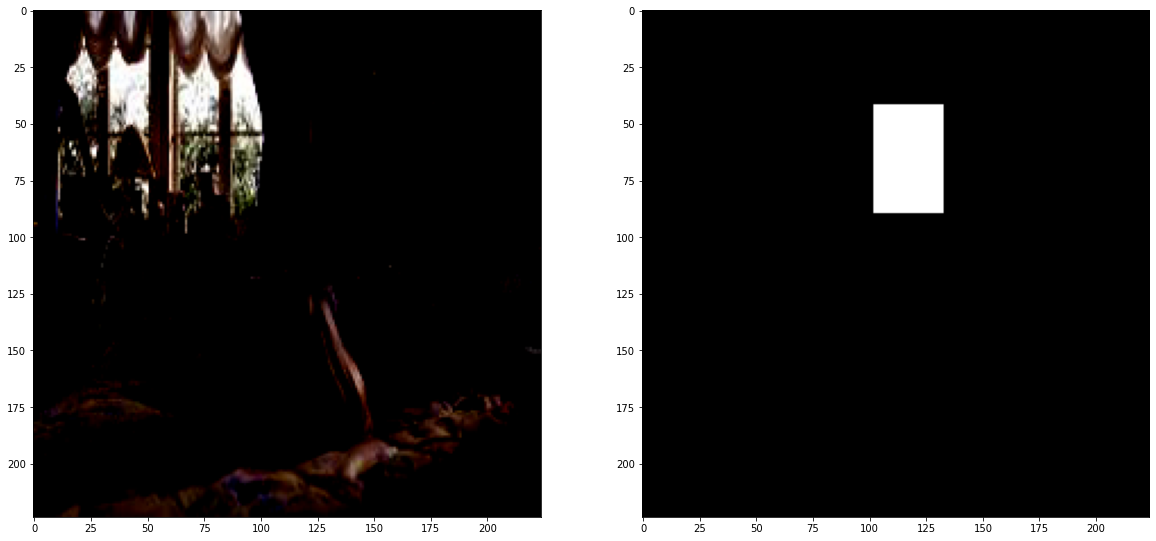

In [ ]:
n = random.choice(range(len(X_train)))
print(n)
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(X_train[n],cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(masks[n],cmap='gray')

plt.show()


### Q2.A

In [ ]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model = create_model()

2021-10-22 14:50:37.783166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Q2. B

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Q2. C

In [ ]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

2021-10-22 14:50:39.359016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
400/400 [==============================] - 388s 959ms/step - loss: 1.2427 - dice_coefficient: 0.5121

Epoch 00001: loss improved from inf to 1.24268, saving model to model-1.24.h5
Epoch 2/10
400/400 [==============================] - 1847s 5s/step - loss: 0.8535 - dice_coefficient: 0.5997

Epoch 00002: loss improved from 1.24268 to 0.85345, saving model to model-0.85.h5
Epoch 3/10
400/400 [==============================] - 366s 914ms/step - loss: 0.7193 - dice_coefficient: 0.6460

Epoch 00003: loss improved from 0.85345 to 0.71927, saving model to model-0.72.h5
Epoch 4/10
400/400 [==============================] - 353s 883ms/step - loss: 0.6647 - dice_coefficient: 0.6677

Epoch 00004: loss improved from 0.71927 to 0.66471, saving model to model-0.66.h5
Epoch 5/10
400/400 [==============================] - 354s 884ms/step - loss: 0.6203 - dice_coefficient: 0.6880

Epoch 00005: loss improved from 0.66471 to 0.62033, saving model to model-0.62.h5
Epoch 6/10
400/400 [===========

### Q2. D

In [ ]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 22s 22s/step - loss: 0.8786 - dice_coefficient: 0.6064


[0.8785530924797058, 0.6064135432243347]

- As per performance tested on test images, Loss is 0.99 and dice_coefficient is 0.5523.Which is not best score for sure, but has scope for improvement.
- First step to improve performance would be to randomize the images for training since test images could be part of single class and which could generate biased results.

### Q3

In [ ]:
tst_img = X_test[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


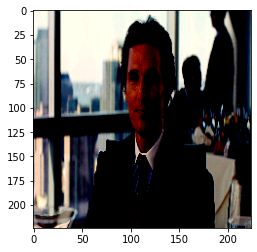

In [ ]:
plt.imshow(tst_img)

In [ ]:
tst_img = cv2.resize(tst_img,(IMAGE_HEIGHT,IMAGE_WIDTH))

In [ ]:
tst_img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


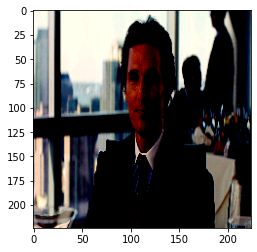

In [ ]:
plt.imshow(tst_img)

In [ ]:
tst_img_1 = np.expand_dims(tst_img,0)

In [ ]:
pred_mask = 1.0 * (model.predict(tst_img_1))

In [ ]:
pred_mask = pred_mask.swapaxes(0,1)
pred_mask = pred_mask.swapaxes(1,2)

In [ ]:
pred_mask.shape

(224, 224, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


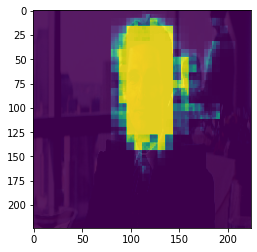

In [ ]:
plt.imshow(tst_img)
plt.imshow(pred_mask,alpha=0.9)

# Part B

### Q1

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
import cv2 # Open cv version 2
import os
import glob
img_dir = "training_images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g') # '*' is used to extract all files in the directory
files = glob.glob(data_path)
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

In [ ]:
dir_list = next(os.walk(img_dir))[2]
dir_list

### Q2

In [ ]:
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]

In [ ]:
import cv2 # Open cv version 2

for i in range (len(dir_list)):
    print("Execution loop=",i)
    # Create a cascade classfier object
    face_cascade=cv2.CascadeClassifier("FF_Default.xml")   # frontal face 
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)

    j=0 

    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    
    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]
        
    
    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

### Q3

In [ ]:
import pandas as pd

DB = pd.DataFrame(x_cord, columns = ['x'])

DB['y']=y_cord
DB['w']=width
DB['h']=height
DB['Total_Faces']=face_detected
DB['Image_Name']=image_name

DB.head()

### Q4

In [ ]:
DB.to_csv("Bounding boxes.csv")